## Yield Spread model
This notebook implements a model to predict new yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers. The model is trained on data from 1 May 2022 to 1 March 2023. The test set is the first 2 weeks of the month of March 2023. 

Last Update: Experimenting with different lenghts of history. In my experiments I found out that we get the best results with trade histories of length 2. 

FICC treasury spreads is the spread calculated by taking the difference of the FICC ycl and the treasury yield for the same maturity. We also experiment with feeding the treasury rates for all maturities. Another feature is the difference in the treasury rate for the target trade and the treasury rate a day before. We also experiment with the Ted rate, which is the difference between the 10-year treasury rate and 2-year treasury rate. A positive ted rate shows a positive outlook for the economy and vice-versa for a negative ted rate. 

Note: Change NUM_FEATURES to 6 if you want to train with treasury spreads

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay



from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


In [2]:
tf.__version__

'2.7.0'

Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [4]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [5]:
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 2
NUM_FEATURES = 6

Checking if the treasury spreads and target attention features are present in PREDICTORS 

In [7]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [8]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
# with fs.open('ficc_training_data_latest/processed_data_2023-02-10-02-58.pkl') as f:
# with fs.open('ahmad_data/processed_data.pkl') as f:
# with fs.open('ficc_training_data_latest/processed_data_2023-03-03-16:43.pkl') as f:
with fs.open('automated_training/processed_data.pkl') as f:
# with fs.open('ahmad_data/processed_data_2023-03-27-17:09.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 1min 29s, sys: 30.8 s, total: 1min 59s
Wall time: 4min 1s


In [9]:
print(f'Restricting history to {SEQUENCE_LENGTH} trades')
data.trade_history = data.trade_history.apply(lambda x: x[:SEQUENCE_LENGTH])
data.target_attention_features = data.target_attention_features.apply(lambda x:x[:SEQUENCE_LENGTH])

Restricting history to 2 trades


In [10]:
data.trade_history.iloc[0].shape

(2, 6)

In [11]:
data.target_attention_features.iloc[0].shape

(2, 3)

Date range of data

In [12]:
data.trade_date.max()

Timestamp('2023-03-31 00:00:00')

In [13]:
data.trade_date.min()

Timestamp('2022-05-02 00:00:00')

In [26]:
len(data)

9130348

### Creating features from trade history

This implementation is an adaption of Charles's implementation 

In [15]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    quantity_diff = np.log10(1 + np.abs(10**trade[2] - 10**row.quantity))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [16]:
%%time
temp = data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)

CPU times: user 2min 25s, sys: 30.5 s, total: 2min 56s
Wall time: 5min 15s


In [17]:
YS_COLS = get_trade_history_columns()

In [18]:
data[YS_COLS] = pd.DataFrame(temp.tolist(), index=data.index)

#### Adding features from Charles's notebook

In [19]:
%%time
data['ttypes'] = (data.last_trade_type.astype(str) + data.trade_type.astype(str)).astype('category')
data['diff_size'] = (data.par_traded.astype(float) - data.last_size).astype(np.float32)
data['abs_last_yield_spread'] = np.abs(data['last_yield_spread'])
data['abs_diff_size'] = np.abs(data['diff_size'])
data['days_duration'] = (data.last_calc_date - data.last_settlement_date).dt.days

CPU times: user 4.04 s, sys: 408 ms, total: 4.44 s
Wall time: 4.44 s


In [20]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']

Adding trade history features to PREDICTORS list

In [21]:
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)

This feature is used to check if there are any NaN values in the trade history. **It is not used to train the model**. 

In [22]:
len(data)

9130348

In [23]:
%%time
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))

CPU times: user 41.5 s, sys: 14.1 s, total: 55.6 s
Wall time: 1min 2s


In [24]:
data = data.dropna(subset=['trade_history_sum'])

In [25]:
len(data)

9130348

For the purpose of plotting, not used in training

In [27]:
data.purpose_sub_class.fillna(0, inplace=True)

Creating new ys label

In [28]:
data['new_ys'] = data['yield'] - data['new_ficc_ycl']

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.

In [29]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'new_ys',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'last_dollar_price',
                     'last_rtrs_control_number',
                     'is_called']

In [30]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]# + ['target_attention_features','yield_spread']]

Checking for missing data and NaN values

In [31]:
len(processed_data)

9130348

In [32]:
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)

In [33]:
processed_data.dropna(inplace=True, subset=PREDICTORS)

In [34]:
len(processed_data)

9130348

In [35]:
processed_data = processed_data[(processed_data.days_to_call == 0) | (processed_data.days_to_call > np.log10(400))]
processed_data = processed_data[(processed_data.days_to_refund == 0) | (processed_data.days_to_refund > np.log10(400))]
processed_data = processed_data[(processed_data.days_to_maturity == 0) | (processed_data.days_to_maturity > np.log10(400))]
processed_data = processed_data[processed_data.days_to_maturity < np.log10(30000)]

In [36]:
len(processed_data)

8522025

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [37]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    fprep = preprocessing.LabelEncoder().fit(data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


#### Splitting the data into train and test sets



In [38]:
train_dataframe = processed_data[processed_data.trade_date < '04-01-2023']

In [39]:
test_dataframe = processed_data[(processed_data.trade_date >= '03-01-2023') & (processed_data.trade_date <= '03-15-2023') ]

In [40]:
len(train_dataframe)

8522025

In [41]:
len(test_dataframe)

347122

Converting data into format suitable for the model

In [42]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [43]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.new_ys

CPU times: user 42 s, sys: 1.99 s, total: 44 s
Wall time: 44 s


In [44]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.new_ys

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


In [45]:
x_train[0].shape

(8522025, 2, 6)

In [46]:
x_test[2].shape

(347122, 48)

## LightGBM

In [47]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY ] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features','yield_spread'])
    return df

In [48]:
trainlabel = train_dataframe.new_ys
testlabel = test_dataframe.new_ys

In [49]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [50]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [51]:
%%time
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 42min 19s, sys: 3.53 s, total: 42min 22s
Wall time: 1min 37s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [52]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(test_dataframe[PREDICTORS]))
delta = testlabel - gbt_pred
print(delta.mean(), delta.abs().mean())

-1.190172138479765 8.140102091075551
CPU times: user 38.4 s, sys: 163 ms, total: 38.6 s
Wall time: 2.93 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

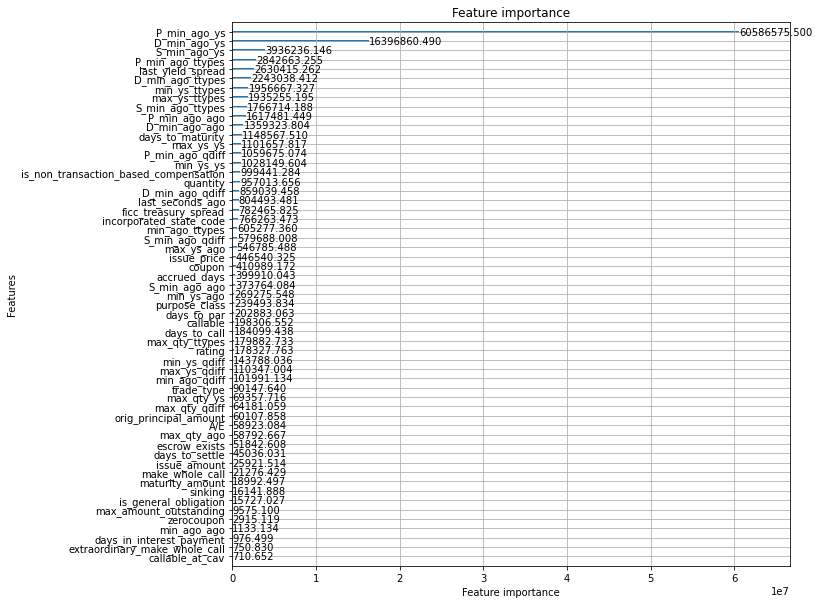

In [53]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10), importance_type='gain')

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [54]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

In [55]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

#### Setting the seed for intialization of the layers

In [56]:
tf.keras.utils.set_random_seed(10)

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [57]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth, name='weights_query') 
        self.wk = layers.Dense(depth, name='weights_key')
        self.wv = layers.Dense(depth, name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [58]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(SEQUENCE_LENGTH, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM')

lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           return_sequences = False,
                           name='LSTM_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
features = lstm_attention_layer(features, features, inputs[1])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu')(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                    input_length= 1,
                                                                    name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='relu')(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

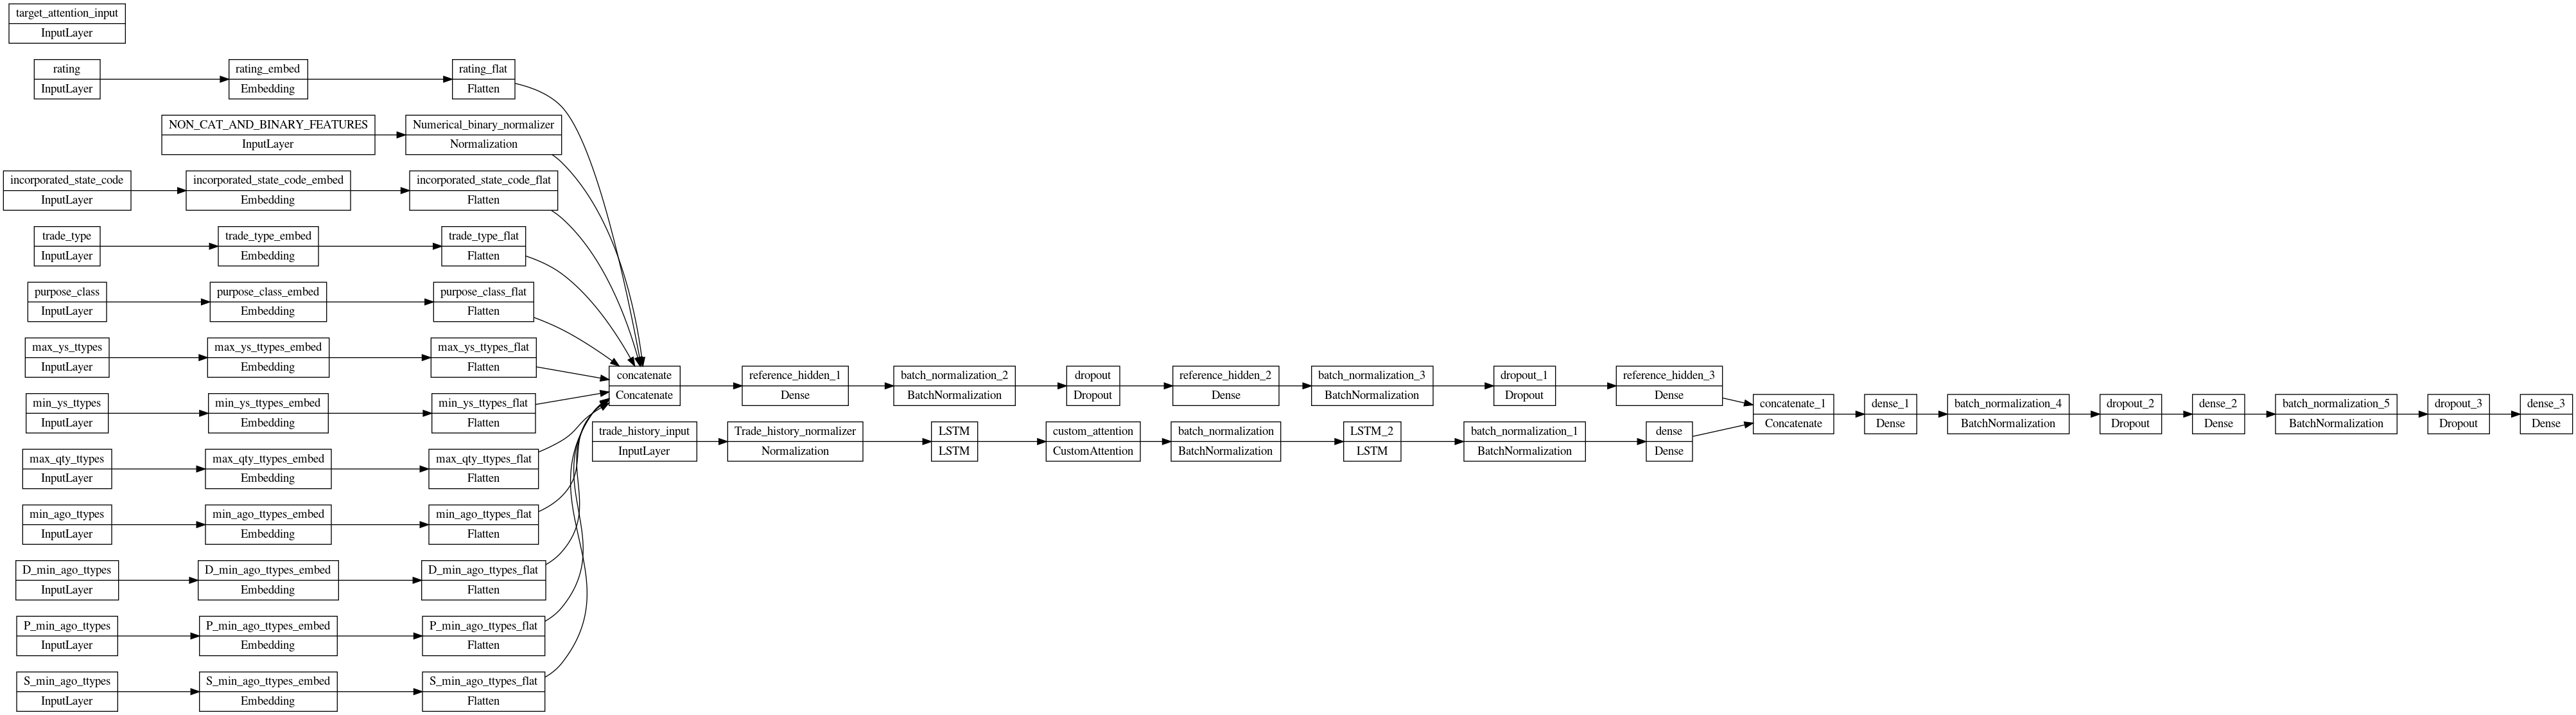

In [60]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [61]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [62]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [63]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [64]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100
7670/7670 [==============================] - 117s 14ms/step - loss: 27.1595 - mean_absolute_error: 27.1595 - val_loss: 10.1578 - val_mean_absolute_error: 10.1578
Epoch 2/100
7670/7670 [==============================] - 109s 14ms/step - loss: 9.2064 - mean_absolute_error: 9.2064 - val_loss: 9.9648 - val_mean_absolute_error: 9.9648
Epoch 3/100
7670/7670 [==============================] - 110s 14ms/step - loss: 8.8335 - mean_absolute_error: 8.8335 - val_loss: 9.6805 - val_mean_absolute_error: 9.6805
Epoch 4/100
7670/7670 [==============================] - 108s 14ms/step - loss: 8.6222 - mean_absolute_error: 8.6222 - val_loss: 9.7623 - val_mean_absolute_error: 9.7623
Epoch 5/100
7670/7670 [==============================] - 108s 14ms/step - loss: 8.4673 - mean_absolute_error: 8.4673 - val_loss: 9.6778 - val_mean_absolute_error: 9.6778
Epoch 6/100
7670/7670 [==============================] - 107s 14ms/step - loss: 8.3457 - mean_absolute_error: 8.3457 - val_loss: 9.4036 - val_mean

Epoch 49/100
7670/7670 [==============================] - 103s 13ms/step - loss: 7.4491 - mean_absolute_error: 7.4491 - val_loss: 9.1271 - val_mean_absolute_error: 9.1271
Epoch 50/100
7670/7670 [==============================] - 103s 13ms/step - loss: 7.4414 - mean_absolute_error: 7.4414 - val_loss: 9.2465 - val_mean_absolute_error: 9.2465
Epoch 51/100
7670/7670 [==============================] - 104s 14ms/step - loss: 7.4387 - mean_absolute_error: 7.4387 - val_loss: 9.1655 - val_mean_absolute_error: 9.1655
Epoch 52/100
7670/7670 [==============================] - 103s 13ms/step - loss: 7.4305 - mean_absolute_error: 7.4305 - val_loss: 9.0867 - val_mean_absolute_error: 9.0867
Epoch 53/100
7670/7670 [==============================] - 104s 14ms/step - loss: 7.4252 - mean_absolute_error: 7.4252 - val_loss: 9.2376 - val_mean_absolute_error: 9.2376
Epoch 54/100
7670/7670 [==============================] - 104s 13ms/step - loss: 7.4237 - mean_absolute_error: 7.4237 - val_loss: 9.2298 - val_me

#### Plotting train vs validation loss

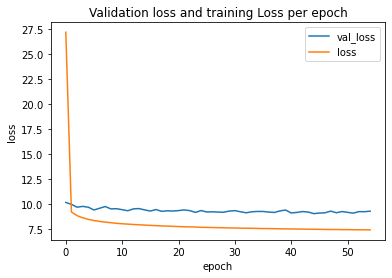

In [65]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Saving the model

In [66]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ahmad_data', f"encoders.pkl")

print("Saving and uploading model")
model.save(f"saved_model_test_{file_timestamp}")
import shutil
shutil.make_archive(f"model_april_1", 'zip', f"saved_model_test_{file_timestamp}")
upload_data(storage_client, 'ahmad_data', f"model_april_1.zip")

file time stamp : 2023-04-03-22-56
Saving encoders and uploading encoders
File encoders.pkl uploaded to ahmad_data.
Saving and uploading model


INFO:tensorflow:Assets written to: saved_model_test_2023-04-03-22-56/assets


INFO:tensorflow:Assets written to: saved_model_test_2023-04-03-22-56/assets


File model_april_1.zip uploaded to ahmad_data.


#### Gigaflops for one epoch of training

In [67]:
avg_time = np.mean(time_callback.times)

In [68]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

212.64110146917562


### Test accuracy on the entire test set

In [69]:
test_dataframe['predicted_ys'] = model.predict(x_test, batch_size=BATCH_SIZE)
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

In [70]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

Test loss: 6.755


In [71]:
print(f"YTW loss: {round(np.mean(np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)), 3)}")

YTW loss: 6.755


#### Accuracy on a daily basis

In [72]:
for d in [d for d in pd.date_range(start="03/01/2023",end="03/31/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.new_ys - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2023-03-01 MAE:6.748419024105014
Date :2023-03-02 MAE:6.4413831072719825
Date :2023-03-03 MAE:6.951793704762242
Date :2023-03-06 MAE:7.428016217903792
Date :2023-03-07 MAE:7.408309461689062
Date :2023-03-08 MAE:6.182448417216675
Date :2023-03-09 MAE:5.765691021120171
Date :2023-03-10 MAE:6.471328836529602
Date :2023-03-13 MAE:6.921481811148478
Date :2023-03-14 MAE:6.808659475513406
Date :2023-03-15 MAE:7.1914396541532675


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [73]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]#& (test_dataframe.coupon == 5)]

In [74]:
len(true_mid)

5741

In [75]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.new_ys

CPU times: user 42.2 ms, sys: 0 ns, total: 42.2 ms
Wall time: 41.5 ms


In [76]:
%%time
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

6/6 [==============================] - 0s 5ms/step - loss: 4.1784 - mean_absolute_error: 4.1784
Test MAE: 4.178
CPU times: user 112 ms, sys: 34.3 ms, total: 146 ms
Wall time: 111 ms


### Plotting new ys vs predicted ys

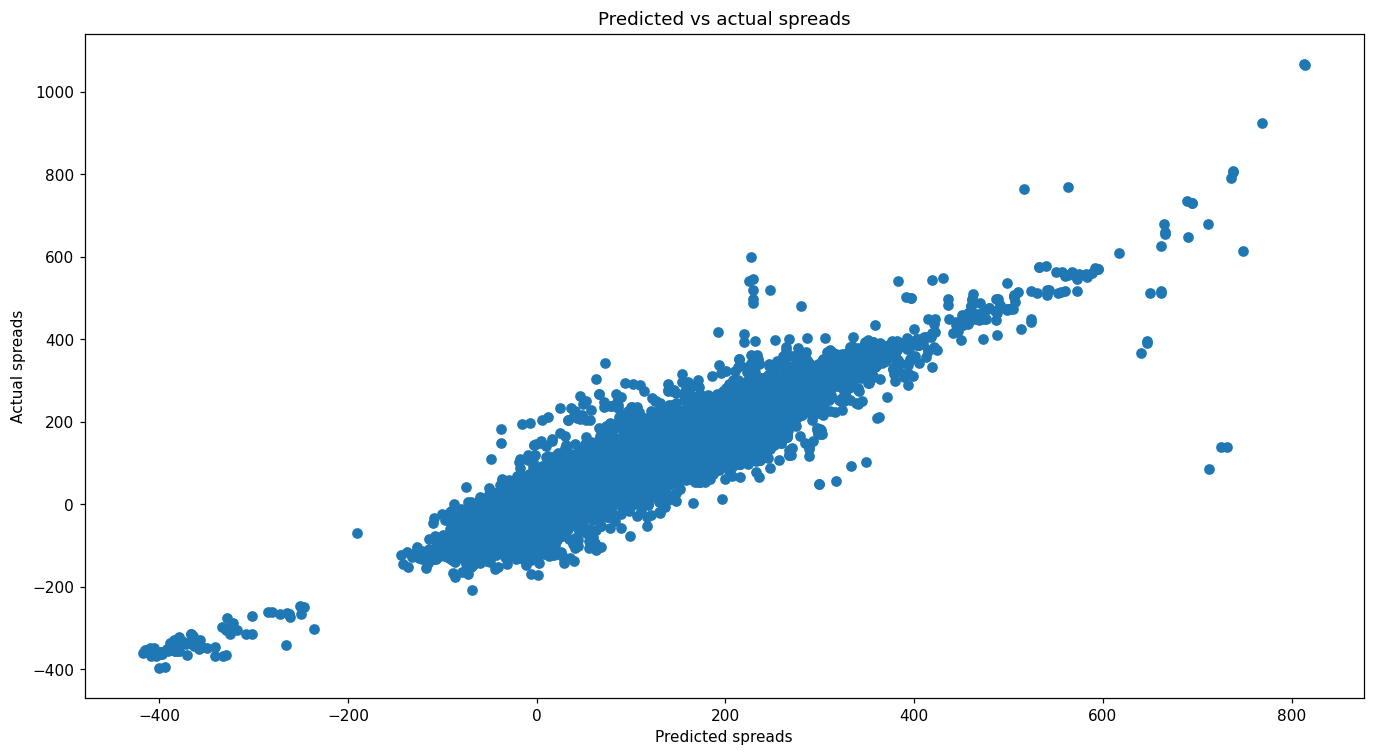

In [94]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted spreads')
plt.ylabel('Actual spreads')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_ys, test_dataframe.new_ys)

array([[<AxesSubplot:title={'center':'new_ys'}>]], dtype=object)

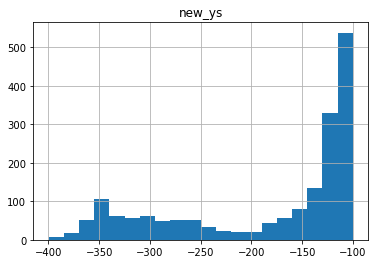

In [114]:
train_dataframe[(train_dataframe.new_ys < -100) & (train_dataframe.new_ys > -400)].hist('new_ys', bins=20)

array([[<AxesSubplot:title={'center':'new_ys'}>]], dtype=object)

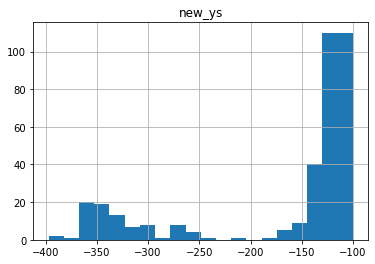

In [115]:
test_dataframe[(test_dataframe.new_ys < -100) & (test_dataframe.new_ys > -400)].hist('new_ys', bins=20)

### Baseline using the last yield spread

In [80]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

16.994243766688598


### Baseline using the last yield spread on dealer dealer true mid trades

In [81]:
dd_dataframe = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
dd_last_ys_preds = dd_dataframe.last_yield_spread
error = dd_dataframe.yield_spread - last_ys_preds


MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(dd_last_ys_preds , dd_dataframe.yield_spread, dd_dataframe)

13.099362164696874


### Regression baseline using previous yield spread optimizing MAE

In [82]:
from statsmodels.regression.quantile_regression import QuantReg

In [83]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [84]:
res = q_reg.fit(q=.5)

In [85]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yield_spread = test_dataframe.yield_spread.values

In [86]:
MAE = np.mean(np.abs(actual_yield_spread - predicted_yield_spread))
print(MAE)

16.9857048112053


In [87]:
print(f'Regression coefficient {res.params[0]}')

Regression coefficient 0.9987857267451269


In [88]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()

In [89]:
y_mae_regression = res.params[0] * x_range

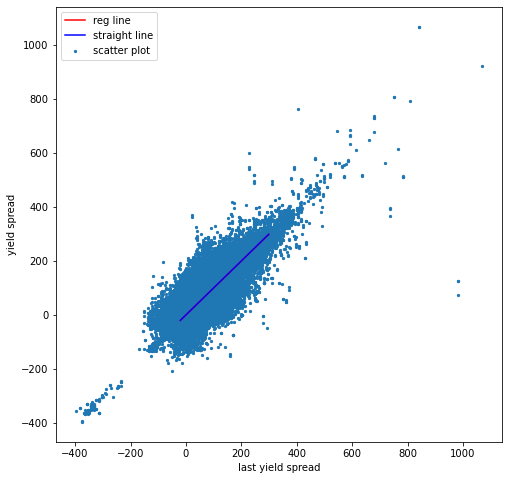

In [90]:
plt.figure(figsize=(8,8))
plt.scatter(test_dataframe.last_yield_spread, actual_yield_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

In [96]:
test_dataframe.predicted_ys.max()

611.3905639648438